In [1]:
%pylab inline

import numpy as np
import pandas as pd

import tensorflow as tf
import torch
import torch.nn as nn

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


https://pozalabs.github.io/transformer/
https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec#b0ed
https://towardsdatascience.com/transformers-141e32e69591
http://jalammar.github.io/illustrated-transformer
https://pytorch.org/docs/stable/torch.html#torch.triu
https://github.com/SamLynnEvans/Transformer/tree/master/data

# Introduction

[Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) 페이퍼를 읽고 문서를 작성합니다. <br>
최대한 간결하고 빠르게 설명하겠습니다.

# Transformer 

## Architecture 

자세하게 설명하기전에 큰 그림부터 대략적으로 설명합니다. 

![](images/transformer-architecture.png)


## Embedding  

일단 한글/영어로 된 부분을 one-hot encoding을 사용해서 변환시켜줍니다.<br>
one-hot encoding의 장단점은 다음과 같습니다.

1. 장점: 단어의 의미를 one-hot vector로 표현함
2. 단점: 문장에서의 위치와, 단어들과의 관계적 정보에 대한 손실

one-hot vector로 변환된 단어를 -> Embedding을 통해서 dense vector로 변환해주면서 의미성 그리고 단어들과의 관계성을 만들어 줄수 있습니다. <br>하지만 역시 여전히 문장안에서의 위치적 정보는 없는 상태입니다. 

$$ \text{embeddings} \in \mathbb{R}^{\text{vocab size } * \ d_{model}}  $$

* $ d_{model} $ : embedding dimension이며, 논문에서는 **512** 사용 



Pytorch에서는 embedding layer를 다음과 같이 만들어 줄 수 있습니다.<br>
Embedding Layer는 위의 그림에서 나왔듯이, Input Embedding, Output Embedding 두군데에서 사용 되기 때문에 <br>
각각 따로 Embedding을 사용하는 것보다는 모듈을 하나 만들어서 동시에 사용하는게 효율적인 접근입니다.

예를 들어서 60000단어 그리고 embedding dimension을 512로 사용시 다음과 같습니다.

In [5]:
import torch.nn as nn

class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int):
        super(EmbeddingLayer, self).__init__()
        self.embed_dim = embed_dim
        self.embed = nn.Embedding(vocab_size, embed_dim)

    def forward(self, x):
        return self.embed(x)
    
embed = EmbeddingLayer(60000, 512)  # 60000단어, 512 embedding dimension 
embed(torch.LongTensor([3, 4, 244])).shape  # [3, 4, 244] 난 단어 index

torch.Size([3, 512])

## Positional Encoding

Transformer는 RNN의 recurrence 사용하지 않기 때문에, sequence상에서의 단어의 위치를 알려줄 필요가 있습니다. <br>
Positional Encoding은 Encoder 그리고 Decoder에 들어가는 embeddings 이후에 사용이 되며, <br>
embeddings와 동일한 $ d_{model} $  (embedding dimension) 을 사용하기 때문에 <br>
단순히 embedding 과 positional embedding을 **더하기**를 해서 사용하면 됩니다.

Positional Encoding은 constant matrix 라고 생각하면 쉽습니다. <br>

$$ \mathbf{pe} \in \mathbb{R}^{\text{max_sequence } x \ d_{model}} $$

* $ \bf{pe} $ : positional encoding matrix
* <span style="color:#555555"> Matrix로 만드는 이유는 단순히 연산 속도를 높이기 위함입니다.</span>


Senquence의 position을 알려주기 위해서 sin, cos 함수를 사용합니다.

$$ \begin{align}
PE(pos, 2i) &= \sin \left( pos / 10000^{2i / d_{model}} \right)  \\
PE(pos, 2i+1) &= \cos \left( pos / 10000^{2i / d_{model}} \right)  
\end{align} $$

* $ pos $ : sentence안에서 단어위 위치 
* $ i $ : Embedding의 $ d_{model} $ (embedding dimension)과 동일하며, 해당 위치를 말합니다.

아래는 positional encoding matrix 를 만드는 방법과, 그래프로 그려서 대략적인 intuition을 알 수 있습니다.<br>
핵심은 특정 wavelength를 만들어낸다는 것이고, monotonic 하게 증가하는 position값이 아니라, <br>
sin, cos을 사용해서 상대적인 값으로 만들어냈다는 것입니다.

### 논문과 가장 흡사하게 구현한 positional matrix

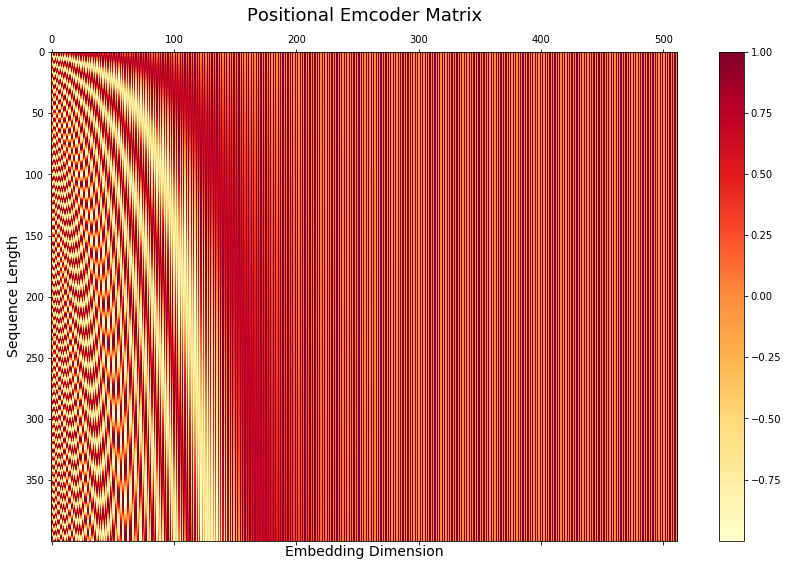

In [3]:
max_seq_len = 400
embed_dim = 512 # 논문에서 d_model 

pe = np.zeros([max_seq_len, embed_dim])
for pos in range(max_seq_len):
    for i in range(0, embed_dim, 2):
        pe[pos, i] = np.sin(pos / (10000 ** ((2 * i) / embed_dim)))
        pe[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1)) / embed_dim)))

# Visualization
fig, ax = plt.subplots(figsize=(15, 9))
cax = ax.matshow(pe, cmap=plt.cm.YlOrRd)
fig.colorbar(cax)
ax.set_title('Positional Emcoder Matrix', fontsize=18)
ax.set_xlabel('Embedding Dimension', fontsize=14)
ax.set_ylabel('Sequence Length', fontsize=14)
print()

### Github에 구현한 코드 (pytorch 문서 참고)

pe의 shape은 (1, 400, 512) 로서, 400은 maximum sequence length 이고 512는 embedding dimension과 동일한 크기. <br>
아래의 코드는 [Pytorch Tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) 에서 참고했습니다.

Text(0, 0.5, 'Sequence Length')

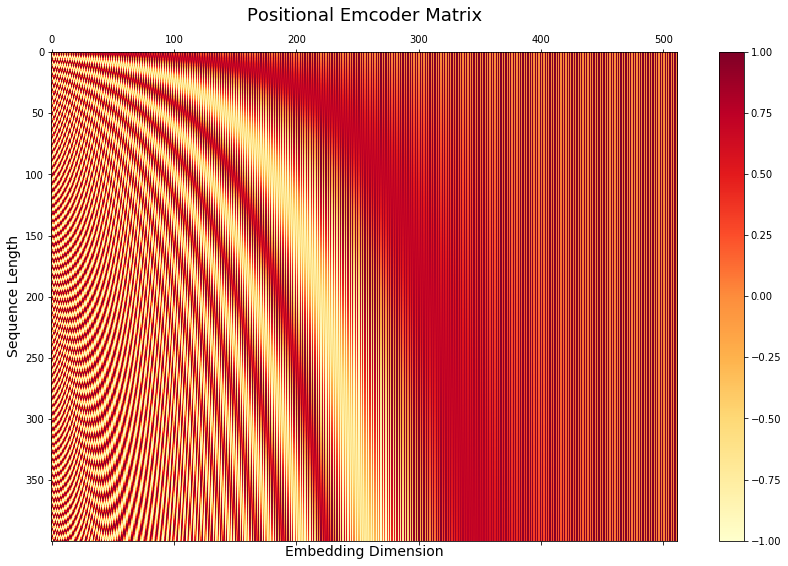

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, embed_dim, dropout=0.1, max_seq_len=400):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_seq_len, embed_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1) 
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].detach()
    
pe_layer = PositionalEncoding(512)
# Input: (256 batch size, 32 sequence length, 512 embedding dimension)
pe_layer(torch.Tensor(np.random.rand(256, 32, 512))).shape  


# Visualization
fig, ax = plt.subplots(figsize=(15, 9))
cax = ax.matshow(pe_layer.pe.squeeze(0), cmap=plt.cm.YlOrRd)
fig.colorbar(cax)
ax.set_title('Positional Emcoder Matrix', fontsize=18)
ax.set_xlabel('Embedding Dimension', fontsize=14)
ax.set_ylabel('Sequence Length', fontsize=14)

## Masking 

Masking은 Transformer에서 중요한 역활을 합니다.


 - **Padding Mask**: input sentence안에 padding이 있을경우 masking은 attention outputs을 zero out 시킵니다. 
 - **Look Ahead Mask**: Decoder가 다음 단어를 예측할때, 그 다음 단어 및 뒤에 나오는 문장을 미리 peaking ahead하지 않도록 막습니다. (A.K.A No Peaking Mask)

### Padding Mask 핵심 내용

source sentence에 적용합니다. <br>
예를 들어, (256, 33) 형태의 tensor가 존재합니다. <br>
(256은 batch_size, 33은 maximum setence length 로서 33보다 작은 문장은 padding index=1로 채워집니다. )

mask는 padding index는 False로 만들고, 글자 부분은 True로 동일하게 만들고, <br>
이후 no peaking mask와 동일한 형태를 가져가지 위해서 차원을 하나 더 더해줍니다. (256, 1, 33) 형태로~

예를 들어서 아래와 같습니다.
```
# Tensor 쉽게 설명하기 위해서 2는 단어, 1은 pad값
tensor([[2., 2., 2., 2., 1., 1., 1.],
        [2., 2., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 1.]])

# mask
tensor([[[ True,  True,  True,  True, False, False, False]],
        [[ True,  True, False, False, False, False, False]],
        [[ True,  True,  True,  True,  True,  True, False]]])
```
 
### No Peaking Mask (Look Ahead Mask 핵심)

Target의 경우 학습시 그 다음 단어를 보지 못하도록 만들어야 합니다. <br>
(256, 33) shape을 -> (256, 33, 33) 형태로 만들며, <br>
33개의 다음 단어를 마스킹한 형태로 나오게 됩니다. 


```
# (3, 1, 7) batch_size=3, sequence_length=7
trg_pad_mask = tensor([[[ True,  True,  True,  True, False, False, False]],
                       [[ True,  True, False, False, False, False, False]],
                       [[ True,  True,  True,  True,  True,  True, False]]])

# (1, 7, 7) batch_size=1, sequence_length=7
nopeak_mask = tensor([[[ True, False, False, False, False, False, False],
                       [ True,  True, False, False, False, False, False],
                       [ True,  True,  True, False, False, False, False],
                       [ True,  True,  True,  True, False, False, False],
                       [ True,  True,  True,  True,  True, False, False],
                       [ True,  True,  True,  True,  True,  True, False],
                       [ True,  True,  True,  True,  True,  True,  True]]])
```


이후 & operation으로 둘을 합치며, 문장마다 단어가 차례대로 가려진 tensor를 만듭니다.

```
trg_mask = trg_pad_mask & nopeak_mask  # (3, 7, 7)

tensor([[[ True, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True, False, False, False]],

        [[ True, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False],
         [ True,  True, False, False, False, False, False],
         [ True,  True, False, False, False, False, False],
         [ True,  True, False, False, False, False, False],
         [ True,  True, False, False, False, False, False],
         [ True,  True, False, False, False, False, False]],

        [[ True, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True, False]]])
```

In [6]:
from typing import Tuple


def create_mask(src: torch.Tensor,
                trg: torch.Tensor,
                src_pad_idx: int,
                trg_pad_idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
    src_mask = _create_padding_mask(src, src_pad_idx)
    trg_mask = None
    if trg is not None:
        trg_mask = _create_padding_mask(trg, trg_pad_idx)  # (256, 1, 33)
        nopeak_mask = _create_nopeak_mask(trg)  # (1, 33, 33)
        trg_mask = trg_mask & nopeak_mask  # (256, 33, 33)

    return src_mask, trg_mask


def _create_padding_mask(seq: torch.Tensor, pad_idx: int) -> torch.Tensor:
    """
    seq 형태를  (256, 33) -> (256, 1, 31) 이렇게 변경합니다.

    아래와 같이 padding index부분을 False로 변경합니다. (리턴 tensor)
    아래의 vector 하나당 sentence라고 보면 되고, True로 되어 있는건 단어가 있다는 뜻.
    tensor([[[ True,  True,  True,  True, False, False, False]],
            [[ True,  True, False, False, False, False, False]],
            [[ True,  True,  True,  True,  True,  True, False]]])
    """
    return (seq != pad_idx).unsqueeze(-2)


def _create_nopeak_mask(trg) -> torch.Tensor:
    """
    NO PEAK MASK
    Target의 경우 그 다음 단어를 못보게 가린다
    """
    batch_size, seq_len = trg.size()
    nopeak_mask = (1 - torch.triu(torch.ones(1, seq_len, seq_len, device=trg.device), diagonal=1)).bool()
    return nopeak_mask



sentences = torch.Tensor([[2., 2., 2., 2., 1., 1., 1.],
                          [2., 2., 1., 1., 1., 1., 1.],
                          [2., 2., 2., 2., 2., 2., 1.]])

src_mask, trg_mask = create_mask(sentences, sentences, 1, 1)

print('sentences:', sentences.shape)
print('src_mask :', src_mask.shape)
print('trg_mask :', trg_mask.shape)

sentences: torch.Size([3, 7])
src_mask : torch.Size([3, 1, 7])
trg_mask : torch.Size([3, 7, 7])


## Residual Dropout

논문의 내용을 간추리면 다음의 순서를 갖습니다. <br>
(최대한 정확하게 해석해서 간추렸는데 좀 틀린부분이 있으면 알려주세요)

1. Sentence Tensor
2. Embeddings 
3. Positional encodings
4. Dropout(0.1)
5. Iterate Sublayers 
   1. Normalization
   2. Do sublayer (such as MultiHead, PositionalFeedForward)
   3. Dropout(0.1)
   4. Skip Connection


![](images/transformer-residual-dropout.png)

## Multi-Headed Attention

지금까지, Embedding Layer 를 거쳐서 단어를 one-hot encoding으로 만들었고, positional encoding을 거쳤습니다.<br>
여기부터 Transformer의 핵심이 되는 attention을 시작할수 있습니다. 

Transformer는 $ d_{model} $ (embedding dimension)에 대해서 single attention function을 사용하는 대신에, <br> 
$ d_{model} $ dimension (embedding dimension)을 갖은 keys, values, queries 를 사용합니다. 

![](images/transformer-multi-head-attention.png)



 - **V**: $ d_{model} $ dimensional **Values**
 - **K**: $ d_{model} $ dimensional **Keys**
 - **Q**: $ d_{model} $ dimensional **Queries**
 - $ d_{model} $ : embedding dimension 이며, 논문에서는 512 사용 
 
### Q, K, and V


**Encoder**에서 Q, K, V 가 뭐 특별한 것이 아니고, positional encoding까지 거친 **embedding vector를 복사 붙여넣기** 한 것입니다. (즉 3개를 복사 붙여넣기 한 것이기 때문에 모두 동일한 것)<br>
해당 embedding vector의 dimension은 batch_size * sequence_lenth * d_model (256, 33, 512) 갖고 있습니다.<br>

**Decoder**에서의 Q, K, V를 단순히 복사 붙여넣기 한것이 아닙니다. <br>

![](images/transformer-decoder.png)

위의 그림처럼 target input 으로 해당되는 Q, K, V는 처음 Multi Head Attention을 들어가기 전에, encoder와 마찬가지로 Q, K, V모두 복사 붙여넣기로 동일한 값이 들어가게 됩니다. <br>
두번재 Multi-Head Attention을 들어가기전에 Endoer의 output과 함께 사용됩니다. <br>

 - Q: 첫번째 multi-head attention의 output (즉 target input) 을 사용
 - K and V: encoder input을 사용 
 
결국 Multi Head Attention의 핵심은 Q 와 K를 dot product로 연결 시켜서 유사성을 찾아내는 것입니다. 


### Linear Model

자 그러면 왜 이렇게 3개로 복사 붙여넣기를 한것인가? <br>
그건 아주 쉽게 말하면 embedding vector를 하나만 사용하는 것보다, 3개의 각각 다른 linear projection을 적용 함으로서 <br>
각각 서로 다른 subspace에서 정보를 끄집어 낼수 있기 때문입니다. -> 그래서 더 좋았다 (뭐 항상 뻔한 내용.. 증명은 못하고 더 좋았다) <br> 
결국 linear transformation을 함으로서 동일한 정보를 다른 방향에서 바라본다. 저는 이렇게 해석하고 있습니다.



### Multi-Head 

예를 들어서 Q (256, 33, 512), K (256, 33, 512), V (256, 33, 512) 이렇게 embedding vectors가 있을때, <br>
33은 33개의 단어가 있다는 뜻이고, 단어 하나당 512개의 dense vector로 표현이 됩니다. <br>
이때 512에 해당되는 부분에 대해서, single attention을 하는 것이 아니라, 512이 부분을 $ h $ 개로 쪼개서 multi-head attention을 합니다.

예를 들어서 512를 8개로 나누면 8 * 64 형태로 나눌수 있습니다.

In [17]:
d_model = 512
n_head = 8
d_k = d_model//n_head
d_v = d_model//n_head

Q = torch.rand(256, 33, d_model)  # Encoder시에는 Q, K, V 는 모두 동일하다
K = Q
V = Q

linear_q = nn.Linear(d_model, n_head*d_k, bias=False)  # 512 * 512 (input * output)
linear_k = nn.Linear(d_model, n_head*d_k, bias=False)  # 512 * 512 (input * output)
linear_v = nn.Linear(d_model, n_head*d_v, bias=False)  # 512 * 512 (input * output)

q = linear_q(Q) # Linear Transformation (256, 33, 512)
k = linear_k(K) # Linear Transformation (256, 33, 512)
v = linear_v(V) # Linear Transformation (256, 33, 512)

# Multi Head : d_model(512) vector부분을 h개 (8개) 로 나눈다
q = q.view(256, 33, n_head, d_k) # (256, 33, 8, 64) 
k = k.view(256, 33, n_head, d_k) # (256, 33, 8, 64) 
v = v.view(256, 33, n_head, d_v) # (256, 33, 8, 64)

$$ \begin{align} \text{MultiHead}(Q, K, V) &= \text{Concat}(head_1, ...., head_h) W^O \\
\text{where head}_i &= \text{Attention} \left( QW^Q_i, K W^K_i, VW^v_i \right)
\end{align} $$

- $ h $ -> $ head_h $ 에서 h를 뜻하며, embed dimension (d_model)이 512일때 n_head=8을 사용. 즉 h = 8
- $ W^Q_i \in \mathbb{R}^{d_{model} \ \times \ d_k} \sim \mathbb{R}^{512 \ \times \ 64} $ 
- $ W^K_i \in \mathbb{R}^{d_{model} \ \times \ d_k} \sim \mathbb{R}^{512 \ \times \ 64} $ ->
- $ W^V_i \in \mathbb{R}^{d_{model} \ \times \ d_v} \sim \mathbb{R}^{512 \ \times \ 64} $ ->
- $ W^O   \in \mathbb{R}^{h d_v \ \times \ d_{model}}  -\sim \mathbb{R}^{8 * 64 \ \times \ 512} $
- $ d_k $ : n_head가 8이고, d_model 이 512일때 512/8 = 64 값이 d_k값
- 논문에서 보면, position-wise feed-forward networks를 설명할때 bias를 명시적으로 선언해주는데, <br>해당 공식에서는 bias를 더해주는 것이 안보임 -> 따라서 MultiHead 부분에서는 bias를 빼준다 


In [14]:
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    """
    512인 embedding vector를 -> n_head에 따라서 나눈다.
    예를 들어, n_head=8일 경우 512 vector를 -> 8 * 64 vector 로 변형한다

    """

    def __init__(self, embed_dim: int, n_head: int, dropout: float = 0.1):
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim
        self.n_head = n_head
        self.dk = embed_dim // n_head
        self.dv = embed_dim // n_head

        self.linear_q = nn.Linear(embed_dim, embed_dim, bias=False)
        self.linear_v = nn.Linear(embed_dim, embed_dim, bias=False)
        self.linear_k = nn.Linear(embed_dim, embed_dim, bias=False)
        self.linear_f = nn.Linear(embed_dim, embed_dim, bias=False)  # Final linear layer

        self.attention = ScaleDotProductAttention(self.dk, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
         * 마지막 skip connection 은 layer 부분에서 구현함
        """
        batch_size, n_head, dk, dv = q.size(0), self.n_head, self.dk, self.dv

        # Linear Transformation (256, 33, 512)
        # Multi Head : d_model(512) vector부분을 h개 (8개) 로 나눈다
        q = self.linear_q(q).view(batch_size, -1, n_head, dk)
        k = self.linear_k(k).view(batch_size, -1, n_head, dk)
        v = self.linear_v(v).view(batch_size, -1, n_head, dv)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        scores = self.attention(q, k, v, mask)

        # multi head dimension 을 원래의 형태로 되돌린다
        # (batch, n_head, seq_len, d_v) (256, 8, 33, 64) --> (batch, seq_len, n_head, d_v) (256, 33, 8, 64)
        scores = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)

        # Final linear Layer
        scores = self.linear_f(scores)

        return scores

    
class ScaleDotProductAttention(nn.Module):
    """
    Attention(Q, K, V) = softmax( (QK^T)/sqrt(d_k) )
    """

    def __init__(self, d_k: int, dropout: float):
        """
        :param d_k: the number of heads
        """
        super(ScaleDotProductAttention, self).__init__()
        self.sqrt_dk = d_k ** 0.5  # 8 = 64**0.5
        self.dropout = nn.Dropout(dropout)

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        :param q: Queries (256 batch, 8 d_k, 33 sequence, 64)
        :param k: Keys    (256, 8, 33, 64)
        :param v: Values  (256, 8, 33, 64)
        :param mask: mask (256, 1, 28) Source Mask
        :return: scaled dot attention: (256, 8, 33, 64)
        """
        attn = (q @ k.transpose(-2, -1)) / self.sqrt_dk
        if mask is not None:  # 논문에는 안나온 내용. 하지만 masking을 해주어야 한다
            mask = mask.unsqueeze(1)
            attn = attn.masked_fill(~mask, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))  # softmax 이후 dropout도 논문에는 없으나 해야 한다
        output = attn @ v  # (256, 8, 33, 64)

        return output


input_tensor = torch.rand(256, 33, 512)

attention = MultiHeadAttention(512, 8)
output = attention(input_tensor, input_tensor, input_tensor, None)

print('output:', output.shape)

output: torch.Size([256, 33, 512])


## Scaled Dot-Product Attention

![](images/transformer-scaled-dot-product.png)

$$ \text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right) $$

Q, K, V 모두 encoder input (256 batch_size, 38 sequence_length, 512 embedding_dimension)에서 만들어진 텐서입니다.<br>


### QK^T

q, k, v를 linear transformation해준뒤, h갯수(8개)로 나누었습니다.<br>
이후 과정은 scaled dot-product attention을 해줘야 합니다. <br>
위의 공식을 보면 먼저 $ Q $ 그리고 $ K^T $ 를 matrix multiplication (dot product)를 해줘야 합니다. <br>

이때 아래의 두개의 코드를 좀 비교해 보겠습니다.

In [18]:
qk = torch.matmul(q, k.transpose(2, 3))  #  (256, 33, 8, 64) @ (256, 33, 64, 8)
print(qk.shape)

torch.Size([256, 33, 8, 8])


In [19]:
_q = q.transpose(1, 2)  # (256, 33, 8, 64) -> (256, 8, 33, 64)
_k = k.transpose(1, 2)  # (256, 33, 8, 64) -> (256, 8, 33, 64)

qk = _q @ _k.transpose(2, 3)  # (256, 8, 33, 33)

첫번째는 matrix multiplication을 해버리면 (256, 33, 8, 8) 값이 나오고 33*8*8=**2112** 가 됩니다. <br>
두번째는 (256, 8, 33, 33) 형태가 나오며, 8*33*33=**8712** 가 나옵니다. <br>

matrix multiplication을 하면서 궁극적으로는 각 vector마다의 similarity를 계산하며, <br>
이때 2112 또는 8712를 정보의 양이라고 했을때, 정보의 손실이 없는 방향으로 계산을 하는게 좋습니다.<br>
여기에 대한 저의 개인적인 해석입니다. (틀릴수 있으니 참고만) 

### 1/sqrt(d_k)

Attention의 방법으로 여러가지 방법이 있을수 있습니다. <br>
예를 들어서 query vector와 key vector를 더할 수도 있고, dot product를 할 수도 있죠. <br>
이 두가지 방법은 모두 많이 사용되는 방법들 입니다.

논문에서는 additive attention이 dot product attention을 뛰어 넘었다고 했습니다. <br>
(1/sqrt(d_k) 사용하지 않은.. 그냥 dot product) <br>

저자의 생각은 dot product를 그냥 사용시 값이 지나치게 커지는 경향이 있고, <br>
softmax 함수가 매우 작은 gradient값을 내놓도록 만들었다고 추정합니다. <br>
이러한 경향을 없애기 위해서 1/sqrt(d_k) 로 scaled dot product 를 해주었습니다.

### Masking and Dropout 

논문에는 나와 있지 않은 2가지가 있습니다.

1. Masking before softmax function
2. Dropout after softmax function

1번의 경우 padding index로 들어간 부분을 mask를 하되, padding부분을 -1000000000 처럼 큰 음수값을 할당 합니다. <br>
softmax 값을 거치면서 해당 값을 0으로 나오게 만듭니다. <br>
즉 exponent는 음수값에 커질수록 0에 가까워지는 성질을 이용한 것입니다. 

```
import torch.nn.functional as F
mask = torch.BoolTensor([True, True, False, False])
vector = torch.FloatTensor([3.5, 2.9, 1, 1])
list(F.softmax(vector.masked_fill(~mask, -1e9)).numpy())
# [0.6456563, 0.3543437, 0.0, 0.0]
```


## Position-wise Feed-Forward Networks

$$ \text{FFN}(x) = \max \left(0, x W_1 + b_1 \right) W_2 + b_2 $$

MultiHead 부분과 더불어, Positiion-wise FFN 도 sublayer안에 적용해야 합니다. <br>
위의 공식에서 보이듯이 2개의 lienar model 그리고 relu를 사용합니다. <br>
MultiHead에서 linear를 사용한 것과는 좀 다르게, bias값이 있는것이 특징인듯 합니다. 

2개의 linear모델을 사용하면서 내부 dimension을 다르게 가져갑니다. <br>
d_ff 라는 값을 사용하며 d_ff=2048을 기본값으로 사용합니다.

이것은 kernel size 1인 convolution을 사용하는데, dimenstion을 다르게 가져가는 것과 같은 것으로 봐도 됩니다.

In [20]:
class PositionWiseFeedForward(nn.Module):

    def __init__(self, embed_dim: int, d_ff: int = 2048, dropout: float = 0.1):
        super(PositionWiseFeedForward, self).__init__()

        self.w_1 = nn.Linear(embed_dim, d_ff)
        self.w_2 = nn.Linear(d_ff, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        논문에서는 Position-wise Feed Forward를 할때 skip connection에 대한 이야기는 없습니다.
        다만 MultiHead 부분에서도
        """
        residual = x
        x = F.relu(self.w_1(x))
        x = self.dropout(x)
        x = self.w_2(x)
        return x + residual

# Training

## Optimizer & Scheduled Learning Rate

Attention is All You Need 논문에서는 다음과 같이 optimizer를 사용했습니다. 

- Adam Optimizer 사용 
- $ \beta_1 = 0.9 $
- $ \beta_2 = 0.98 $
- $ \epsilon = 10^{-9} $

또한 learning rate는 training 도중에, 다음의 공식대로 변경되도록 하였습니다. 

$$ lr = d_{model}^{-0.5} \cdot \min \left( \text{step_num}^{-0.5}, \text{step_num} \cdot \text{warmup_steps}^{-1.5} \right) $$

예를 들어서 warumup step=200 일 경우 다음과 같은 그래프가 그려지게 됩니다.<br>
즉.. warmup_steps 까지는 learning rate는 linear하게 증가하게 됩니다. <br>
하지만 step의 inverse square root 에 따라서 감소하게 됩니다.

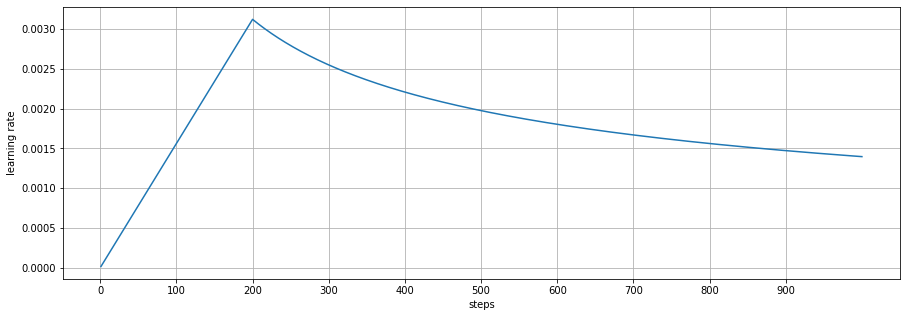

In [29]:
d_model = 512
warmup_step = 200

lrs = []
for step in range(1, 1001):
    lr = d_model**-0.5 * min(step**-0.5, step * warmup_step**-1.5)
    lrs.append(lr)

# Visualization
subplots(1, figsize=(15, 5))
ax = sns.lineplot(range(1, 1001), lrs)
ax.set_xticks(range(0, 1000, 100))
ax.set_xlabel('steps')
ax.set_ylabel('learning rate')
grid()

## Cross Entropy Loss Function

- y_pred: (batch * seq_len, trg_vocab_size)
- y_true: (batch * seq_len)

Loss는 cross entropy를 사용하며 내부적으로 log-softmax 를 사용합니다. <br>
중요한점은 padding값은 loss 계산에서 빠져야 합니다. 

Pytorch에서는 F.cross_entropy를 사용할수 있으며 ignore_index=trg_pad_idx 를 사용해서 <br>
padding값에 대해서는 무시하도록 만들수 있습니다. (개편하네)

### Pytorch

In [144]:
import torch.nn.functional as F

y_pred = torch.FloatTensor([[1, 3, 7], [33, 5, 1], [4, 10, 0.1], [5, 2, 0]])

y_true = torch.LongTensor([2, 0, 1, 0])
print('correct     :', F.cross_entropy(y_pred, y_true, reduction='sum')) # 잘맞는 경우 0.0781

y_true = torch.LongTensor([0, 2, 2, 2])
print('incorrect   :', F.cross_entropy(y_pred, y_true, reduction='sum')) # 안맞는 경우 52.9781

y_true = torch.LongTensor([2, 0, 2, 2])
print('half correct:', F.cross_entropy(y_pred, y_true, reduction='sum')) # 2개만 맞는 경우 14.9781

correct     : tensor(0.0781)
incorrect   : tensor(52.9781)
half correct: tensor(14.9781)


In [132]:
def my_cross_entropy(y_pred, y_true):
    one_hot = torch.zeros_like(y_pred).scatter(1, y_true.view(-1, 1), 1)
    return -1*(one_hot * torch.log_softmax(y_pred, axis=1)).sum()

y_pred = torch.FloatTensor([[1, 3, 7], [33, 5, 1], [4, 10, 0.1], [5, 2, 0]])
y_true = torch.LongTensor([2, 0, 1, 0])
print('correct  :',  my_cross_entropy(y_pred, y_true))

y_true = torch.LongTensor([0, 2, 2, 2])
print('correct  :',  my_cross_entropy(y_pred, y_true))

y_true = torch.LongTensor([2, 0, 2, 2])
print('correct  :',  my_cross_entropy(y_pred, y_true))

correct  : tensor(0.0781)
correct  : tensor(52.9781)
correct  : tensor(14.9781)


### Numpy

In [145]:
def my_softmax(x, axis=None):
    exp_x = np.exp(x)
    return exp_x/exp_x.sum(axis=axis).reshape(-1, 1)

def my_cross_entropy(y_pred, y_true, axis=None):
    one_hot = np.zeros_like(y_pred)
    one_hot[np.arange(y_true.shape[0]), y_true] = 1
    
    _softmax = my_softmax(y_pred, axis=axis)
    return np.sum(-one_hot * np.log(_softmax)).round(4)
    
y_pred = np.array([[1, 3, 7], [33, 5, 1], [4, 10, 0.1], [5, 2, 0]])

y_true = np.array([2, 0, 1, 0])
print('correct     :', my_cross_entropy(y_pred, y_true, axis=1)) # 잘맞는 경우 0.0781

y_true = torch.LongTensor([0, 2, 2, 2])
print('incorrect   :', my_cross_entropy(y_pred, y_true, axis=1)) # 안맞는 경우 52.9781

y_true = torch.LongTensor([2, 0, 2, 2])
print('half correct:', my_cross_entropy(y_pred, y_true, axis=1)) # 안맞는 경우 14.9781

correct     : 0.0781
incorrect   : 52.9781
half correct: 14.9781


In [151]:
x = torch.Tensor([24, 15, 30, 20])
x.max(0)

torch.return_types.max(
values=tensor(30.),
indices=tensor(2))

# Pytorch Tutorial

## torch.triu

정사각형의 n by n 매트릭스가 있을때, 위쪽 삼각부분만 리턴시킨다.

In [11]:
print('[Diagonal=0]')
print(torch.triu(torch.ones(5, 5)))

print('\n[Diagonal=1]')
print(torch.triu(torch.ones(5, 5), diagonal=1))

print('\n[Diagonal=-1]')
print(torch.triu(torch.ones(5, 5), diagonal=-1))

[Diagonal=0]
tensor([[1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]])

[Diagonal=1]
tensor([[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])

[Diagonal=-1]
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.]])


## torch.narrow (narrow dimension)

Returns a new tensor that is a narrowed version of :attr:`input` tensor. <br>
The dimension :attr:`dim` is input from :attr:`start` to :attr:`start + length`. <br>
The returned tensor and :attr:`input` tensor share the same underlying storage.

In [12]:
x = torch.arange(1, 10).reshape(-1, 3)

print('[original]')
print(x)

print('\n[dim=0, start=0, length=2]')
print(torch.narrow(x, dim=0, start=0, length=2))  # == x[:2]

print('\n[dim=1, start=0, length=1]')
print(torch.narrow(x, dim=1, start=0, length=2))  # == x[:, :2]


[original]
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

[dim=0, start=0, length=2]
tensor([[1, 2, 3],
        [4, 5, 6]])

[dim=1, start=0, length=1]
tensor([[1, 2],
        [4, 5],
        [7, 8]])


## nn.Linear

In [21]:
linear = nn.Linear(512, 32, bias=False)
x = torch.Tensor(torch.rand(256, 38, 512))

print('x             :', x.shape)
print('linear weights:', linear.weight.shape)
print('linear(x)     :', linear(x).shape)
print('same?         :', torch.all(linear(x) == x @ linear.weight.T))

x             : torch.Size([256, 38, 512])
linear weights: torch.Size([32, 512])
linear(x)     : torch.Size([256, 38, 32])
same?         : tensor(True)


## maked_fill

 - True: -1 로 채운다
 - False: arange 값으로 채운다

In [40]:
bools = torch.BoolTensor([[True, True, True, True, True], 
                          [False, False, False, False, False]])

result = torch.arange(0, 5).masked_fill(bools, -1)

print('[Masked Filled]')
print(result)

[Masked Filled]
tensor([[-1, -1, -1, -1, -1],
        [ 0,  1,  2,  3,  4]])


## Normal Layer

### Pytorch Builtin Normal Layer

In [14]:
# Pytorch Builtin LayerNorm
norm = nn.LayerNorm(512, eps=1e-6)

input_tensor = torch.rand(128, 33, 512)
h = norm(input_tensor)
print(f'nn.LayerNorm | mean: {h.mean():.2f} | var: {h.var():.2f} | std: {h.std():.2f} | ' 
      f'weight: {norm.weight.mean():.2f} {tuple(norm.weight.shape)} | '
      f'bias: {norm.bias.mean():.2f} {tuple(norm.bias.shape)}')

nn.LayerNorm | mean: -0.00 | var: 1.00 | std: 1.00 | weight: 1.00 (512,) | bias: 0.00 (512,)


### My Normal Layer

In [15]:
import numbers

class NormLayer(nn.Module):
    __constants__ = ['norm_shape', 'weight', 'bias', 'eps']
    
    def __init__(self, norm_shape, eps=1e-6):
        super(NormLayer, self).__init__()
        if isinstance(norm_shape, numbers.Integral):
            norm_shape = (norm_shape,)
        self.norm_shape = norm_shape

        # create two trainable parameters to do affine tunening 
        self.weight = nn.Parameter(torch.ones(*self.norm_shape), requires_grad=True)
        self.bias = nn.Parameter(torch.zeros(*self.norm_shape), requires_grad=True)
        self.eps = eps
        
    def forward(self, x):
        norm = self.weight * (x - x.mean(dim=-1, keepdim=True))
        norm /= (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm
    
# My Layer Norm
norm = NormLayer(512)

input_tensor = torch.rand(128, 33, 512)
h = norm(input_tensor)
print(f'nn.LayerNorm | mean: {h.mean():.2f} | var: {h.var():.2f} | std: {h.std():.2f} | ' 
      f'weight: {norm.weight.mean():.2f} {tuple(norm.weight.shape)} | '
      f'bias: {norm.bias.mean():.2f} {tuple(norm.bias.shape)}')

nn.LayerNorm | mean: 0.00 | var: 1.00 | std: 1.00 | weight: 1.00 (512,) | bias: 0.00 (512,)
